# <span id="chap_er_networks_components"></span> The components of an ER network

The [components](concepts-paths.ipynb#sec_concepts_paths_concectedness) of a network are its connected sub-networks. A network may have one or more components. Suppose we construct an ER network: is it connected?

Returning to the way we [created](er-networks.ipynb#sec_er_networks_building) an ER network earlier, we started with an empty network and then added edges between pairs of nodes with a given probability $\phi$. An empty network is maximally disconnected: an $N$-node network will have $N$ components. As we add edges, the number of components will decrease as nodes become connected. But *how fast* does this occur? As we add edges, what happens to the number of components in the network?

The `NetworkX` function `number_connected_components()` computes the number of components in a network. To explore this question, then, we could create a network and progressively add edges to it, counting the number of components as we go. Using our earlier [from-scratch generator](er-networks.ipynb#sec_er_networks_building) is a possibility: however, looking at the code, while the *result* is a random network, the *process* by which edges are added is actually very regular, and we should probably avoid such unnecessary regularity in case it makes a difference. One could easily imagine that adding nodes in a regular fashion might generate components faster (or slower?) than truly random addition.

What we could do instead is to take the *resulting* random network and re-construct it by adding its edges randomly. This destroys any artefacts coming from the way in which we added the edges in the first place.

In [2]:
import networkx
import math
import numpy
import numpy.random as rnd

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import seaborn

/Users/sd/research/writing/complex-networks-complex-processes/notebook/cncp/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/sd/research/writing/complex-networks-complex-processes/notebook/cncp/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


We first define an iterator that will randomise a list:

In [3]:
from copy import copy

class permuted:
    """An iterator for the elements of an array in a random order."""
    
    def __init__( self, es ):
        """Return an iterator for the elements of an array in a random order."""
        self.elements = copy(es)            # copy the data to be permuted
    
    def __iter__( self ):
        """Return the iterator."""
        return self
    
    def next( self ):
        """Return a random element."""
        n = len(self.elements)
        if n == 0:
            raise StopIteration
        else:
            i = int(rnd.random() * n)
            v = self.elements[i]
            del self.elements[i]
            return v

We can then write a function that replays a list of edges in random order into another, initially empty, network, computing the number of components as we go:

In [4]:
def growing_component_numbers( n, es ):
    """Build the graph with n nodes and add edges from es, returning
    a list of the number of components in the graph as we add edges in a
    random order taken from a list of possible edges.
    
    n: the number of nodes
    es: the edges"""

    # create an empty graph
    g = nx.empty_graph(n)

    # add edges to g taken at random from the edge set,
    # and compute components after each edge
    cs = []
    for e in permuted(es):
        g.add_edge(*e)

        nc = nx.number_connected_components(g)
        cs.append(nc)
    return cs

Let's try this on a moderately-sized ER network and plot the number of components against the number of edges:

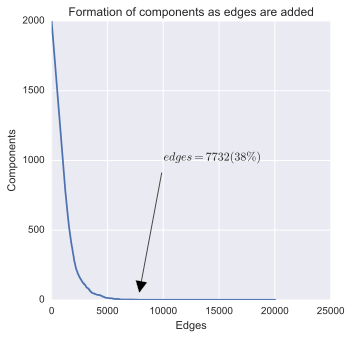

In [28]:
# create an ER networks and grab its edges
er = nx.erdos_renyi_graph(2000, 0.01)
es = er.edges()

# replay these edges
component_number = growing_component_numbers(2000, es)

# plot components against edges
fig = plt.figure(figsize = (5, 5))
plt.title("Formation of components as edges are added")
plt.xlabel("Edges")
plt.ylabel("Components")
plt.plot(range(len(component_number)), component_number)

# edge at which the giant component forms
i = component_number.index(1)

# highlight the formation of the giant component
ax = fig.gca()
ax.annotate("$edges = {e} ({p}\\%)$".format(e = i, p = int(((i + 0.0) / len(es)) * 100)),
            xy = (i, 1),
            xytext = (len(component_number) / 2, component_number[0] / 2),
            arrowprops = dict(facecolor = 'black', width = 1, shrink = 0.05))

_ = plt.show()

The giant component forms well before we've added all the edges.

But *how* does the giant component form? Does it steadily accrete, or does it form suddenly as previously disconnected components connect? We can explore this by plotting the size of the largest component as we add edges, using the function `connected_components()` that returns a list of components, largest first: 

In [29]:
def growing_component_sizes( n, es ):
    """Build the graph with n nodes and edges taken from es, returning
    a list of the size of the largest component as we add edges in a
    random order taken from a list of possible edges.
    
    n: number of edges
    es: the edges"""
    g = nx.empty_graph(n)

    cs = []
    for e in permuted(es):
        g.add_edge(*e)

        # pick the largest component (the one with the longest list of node members)
        gc = len(max(nx.connected_components(g), key = len))
        
        cs.append(gc)
    return cs

Let's plot the size of the largest component against the number of edges added. Since we know when the giant component, we can limit ourselves to just plotting this region. For completeness, let's also show the *number* of components on the same axes:

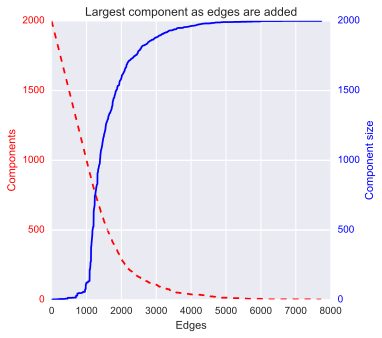

In [49]:
# compute list of component sizes as we add edges, re-using the
# ER edges we computed earlier
#component_size = growing_component_sizes(2000, es)

fig = plt.figure(figsize = (5, 5))
plt.title("Largest component as edges are added")

# plot the number of components
ax1 = fig.gca()
ax1.set_xlabel("Edges")
ax1.set_ylabel("Components", color = 'r')
ax1.plot(range(i), component_number[:i], 'r--', label = 'Components')
for t in ax1.get_yticklabels():
    t.set_color('r')

# plot component sizes against edges
ax2 = ax1.twinx()
ax2.set_ylabel("Component size", color = 'b')
ax2.plot(range(i), component_size[:i], 'b-', label = "Component size")
for t in ax2.get_yticklabels():
    t.set_color('b')

_ = plt.show()

Now isn't *that* interesting... Let's try to interpret what's happening. Quite early-on in the process of adding edges, there's a sudden jump in the size of the largest component in the network. Well before we get to the giant component, we start getting a component of hundreds, and then thousands, of nodes. The process by which we're adding edges is random and smooth, but nonetheless results in a sudden change in the connectivity of the network. The network consists of lots of small components that suddenly &ndash; over the course of adding a relatively small number of edges &ndash; join up and create an enormously larger component consisting of most of the nodes, which then itself gradually grows until it contains *all* the nodes. Below this threshold the network is essentially disconnected; above it, it's essentially connected, and becomes completely connected very quickly thereafter.

This is the first example we've seen of a *critical transition* or *phase change*: during a steady, incremental, process, the network changes from one state into another, very different state &ndash; and does so almost instantaneously.

We should examine the area around the critical point in more detail. First we need to locate it. Since the characteristic of the critical point is that the slope of the graph suddenly increases, we can look for it by looking at the slope of the data series: 

In [50]:
def critical_point( cs, slope = 1 ):
    """Find the critical point in a sequence. We define the critical point
    as the index where the derivative of the sequence becomes greater than
    the desired slope. We ignore the direction of the slope.
    
    cs: the sequence of component sizes
    slope: the desired slope of the graph (defaults to 1)"""
    for i in xrange(1, len(cs)):
        if abs(cs[i] - cs[i - 1]) > slope: 
            return i
    return None

We can then plot the vicinity of the critical point to see the critical transition in detail:

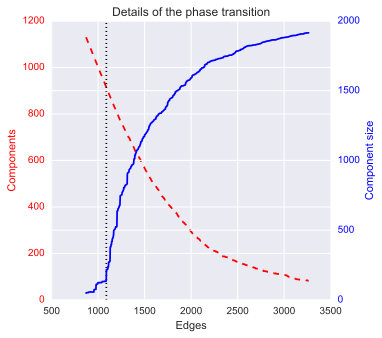

In [66]:
# find the critical point
cp = critical_point(component_size, slope = 50)

# some space either side of the critical point, with the
# right-hand side being more interesting and so getting more
bcp = int(cp * 0.8)
ucp = int(cp * 3)

fig = plt.figure(figsize = (5, 5))
plt.title("Details of the phase transition")

# plot the number of components
ax1 = fig.gca()
ax1.set_xlabel("Edges")
ax1.set_ylabel("Components", color = 'r')
ax1.plot(range(bcp, ucp), component_number[bcp:ucp], 'r--', label = 'Components')
for t in ax1.get_yticklabels():
    t.set_color('r')

# plot component sizes against edges
ax2 = ax1.twinx()
ax2.set_ylabel("Component size", color = 'b')
ax2.plot(range(bcp, ucp), component_size[bcp:ucp], 'b-', label = "Component size")
for t in ax2.get_yticklabels():
    t.set_color('b')

# add a line to show where we decided the critical point was
ax1.plot([cp, cp],           # x's: vertical line at the critical point
         ax1.get_ylim(),     # y's: the y axis' extent
         'k:')

_ = plt.show()

So while the *number of components* comes down fairly smoothly, the *size of the largest component* jumps quickly as smaller components amalgamate.

Let's take a step back. We have explored the critical threshold of a *particular* ER network configuration. Does the giant component always form, regardless of configuration? Or do factors like the mean degree of the network also exert an influence? We coud continue to expore these issues in simulation &ndash; for example by testing the behaviour of several different networks to try to tease-out some regularities &ndash; but this is an example of a behaviour that it's possible to study analytically, at least for ER networks.

## <span id="sec_er_networks_components_critical_threshold"></span> The critical threshold and the giant component

When we looked at components [earlier](er-networks-components.ipynb), we discovered that a "giant" component forms rapidly as we add edges to the network. The location of this critical threshold can be determined analytically, removing the need for simulation. How this is done is another useful illustration of mathematical reasoning applied to networks.

Suppose we have a network with $N$ nodes and edge probability $\phi$, and suppose further that this network has a giant component. How does a node $i$ come to *not* be in the giant component? This happens when $i$ is not adjacent to a node that *is* in the giant component. That means that, for every other node $j$ in the network, either:

* $i$ is not linked to $j$; or
* $i$ is linked to $j$, but $j$ is also not in the giant component

Let $u$ denote the fraction of nodes that are not in the giant component. In an ER network, this means that $u$ is also the probability that a node chosen at random is not in the giant component. We can use $u$ to capture the two cases above. The probability that $i$ is not adjacent to $j$ is simply $1 - \phi$, the probability of not having made an edge between $i$ and $j$. The probability that a node $j$ adjacent to $i$ is not in the giant component is $\phi u$, the probability of there being ad edge between $i$ and $j$ *and* that $j$ is not in the giant component. Therefore the total probability of a random node $i$ not being in the giant component is given by the sum of these two probabilities, $1 - \phi + \phi u$. We know that $i$ has $N - 1$ other nodes to connect to, or approximately $N$ in the limit of a large network, so we find the probability of a node $i$ not being in the giant component as:

\begin{align*}
    u &= (1 - \phi + \phi u)^N \\
      &= (1 - \phi(1 - u))^N \\
      &= \bigg ( 1 - \frac{\langle k \rangle}{N} (1 - u) \bigg )^N
\end{align*}

(making use of $\phi = \frac{\langle k \rangle}{N}$ from [above](#sec_er_mean_degree_maths)). Notice that $u$ appears on both sides of the equation. If we take logs we get:

\begin{align*}
    \log u &= N \log \bigg ( 1 - \frac{\langle k \rangle}{N} (1 - u) \bigg ) \\
           &= -N \frac{\langle k \rangle}{N} (1 - u) \\
           &= -\langle k \rangle(1 - u)
\end{align*}

and so:

$$
    u = e^{-\langle k \rangle(1 - u)}
$$

It's perhaps awkward to reason in terms of the fraction of nodes *not in* the giant component, so if we denote the fraction of nodes that *are in* the giant component by $S = 1 - u$ then we can re-arrange this expression to get:

$$
    S = 1 - e^{-\langle k \rangle S}
$$

Again we have $S$ on both side. If we re-arrange to solve for $\langle k \rangle$, we get:

\begin{align*}
                S - 1 &= - e^{-\langle k \rangle S} \\
                1 - S &= e^{-\langle k \rangle S} \\
         \log (1 - S) &= -\langle k \rangle S \\
    \langle k \rangle &= - \frac{\log (1 - S)}{S}
\end{align*}

What does all this mean? To find solutions for $S$, the fractional size of the giant component for different mean degrees,  we have to fall back on graphical means, plotting $y = 1 - e^{-\langle k \rangle S}$ for different values of $\langle k \rangle$. The solutions are then where these curves meets the line $y = S$. We show this in the left-hand plot below. In the right-hand plot we  show the size of the giant component for different values of $\langle k \rangle$.

In [ ]:
# y = 1 - e^{<k> S} for some parameter <k>
def make_er_giant_component_fraction( kmean ):
    def model( S ):
        return 1 - math.exp(-kmean * S)
    return model

# y = log(1 - S) / S
def er_giant_component_degree( S ):
    return -(math.log(1 - S) / S)

# plot along the closed interval (0, 1)
ss = np.linspace(0.001, 0.999)

# create a figure with two side-by-side sub-plots
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
plt.subplots_adjust(wspace = .5)                   # a bit more space between sub-plots

# plot the formation of the giant component
ax[0].set_title('Formation of giant component')
ax[0].set_xlabel('$S$')
ax[0].set_ylabel('$y$')

# plot the fraction S for some different values of <k>
for kmean in [0.1, 0.5, 1.0, 1.5, 2.0, 5.0]:
    gcf = make_er_giant_component_fraction(kmean)
    _ = ax[0].plot(ss, map(gcf, ss))
    
    # label each curve off to the right of the graph axes,
    # at the same height as the end of the curve
    ax[0].text(1.02, gcf(0.999), '$\\langle k \\rangle = ' + str(kmean) + '$')

# add the solution line y = S
ax[0].plot([0, 1], [0, 1], 'k--', label = '$y = S$')

# plot the fraction S of the giant component as a function of <k>
ax[1].set_xlim([0, 5])
ax[1].set_title('Size of giant component')
ax[1].set_xlabel('$\\langle k \\rangle$')
ax[1].set_ylabel('S')
_ = ax[1].plot(map(er_giant_component_degree, ss), ss)

There are two messages from these graphs. On the left-hand side, different values of $\langle k \rangle$ give different size of giant component. The curve for $\langle k \rangle = 2$, for example, results in $S = 0.8$: the giant component will occupy four-fifths of the nodes. For $\langle k \rangle < 1$, no giant component will form at all. On the right-hand side, the size of the giant component asymptotically approaches 1 as $\langle k \rangle$ increases.

We should check these results experimentally, just to be sure:

In [ ]:
def make_er_giant_component_size_by_kmean( n ):
    """Return a model function for a network with the given number
    of nodes, computing the fractional size of the giant component
    for different mean degrees."""
    def model( kmean ):
        phi = kmean / n
        er = nx.erdos_renyi_graph(n, phi)
        gc = len(max(nx.connected_components(er), key = len))
        S = (gc + 0.0) / n
        return S
    return model

fig = plt.figure(figsize = (5, 5))
plt.title('Fractional size of giant component')
plt.xlabel('$\\langle k \\rangle$')
plt.ylabel('$S$')
kmeans = np.linspace(0.1, 5.0, num = 20)
_ = plt.plot(kmeans, map(make_er_giant_component_size_by_kmean(2000), kmeans), 'r-')

You'll notice this curve doesn't exactly follow what the analytical solution would suggest: we seem to get take-off slightly before $\langle k \rangle = 1$, and the curve isn't smooth. The analytical model is expressed in terms of averages, while the graph above is generated from *one specific* ER network that *might* happen to have properties that cause a giant component to form, or not form, or form with a slightly different size than predicted, just becase of some fluke of the edges. The mathematical expression gives us the expected behaviour that's overwhemingly probable in the case of large ($N \rightarrow \infty$) networks but can be misleading in smaller networks.  